### Creating Relevant Folders Using Labels csv file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [ ]:
import shutil, os
import pandas as pd

# read label
labels = pd.read_csv("newlabels.csv")
# sort label
labels = labels.sort_values('label')

labels['label'] = labels['label'].astype(str)

# take unique labels
class_names = list(labels.label.unique())

#creating subfolders
for i in class_names:
    os.makedirs(os.path.join('train2_', i))

for c in class_names:
    for i in list(labels[labels['label']==c]['id']):

        #create path to the image 
        get_image = os.path.join('train2',i)

        #If image has not already exist in the new folder create one        
        if not os.path.exists('train2_/'+c+i):
            # move the image 
            move_image_to_cat = shutil.move(get_image,'train2_/'+c)

In [ ]:
number_of_images = {}

for dir in os.listdir("train2_"):
    number_of_images[dir] = len(os.listdir(os.path.join('train2_', dir)))

In [ ]:
number_of_images.items()

In [ ]:
# defining a function for splitting data between train, test and validation sets
def dataFolder(path, split):
    
    if not os.path.exists("./"+path):
        os.mkdir("./"+path)
        
        for dir in os.listdir('train2_'):
            os.makedirs("./"+path+"/"+dir)
            
            for img in np.random.choice(a = os.listdir(os.path.join("train2_", dir)),
                                       size = (math.floor(split*number_of_images[dir]) - 2),
                                       replace = False):
                O = os.path.join("train2_", dir, img)
                D = os.path.join("./" + path, dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print( f"{path} Folder Already Exists")

In [ ]:
dataFolder("Train", 0.7)

In [ ]:
dataFolder("Val", 0.15)

In [ ]:
dataFolder("Test", 0.15)

### CNN Using Keras

In [3]:
import keras
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
#from keras.preprocessing.image import 
from keras_preprocessing.image import ImageDataGenerator

In [4]:
#CNN Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (96,96,3), padding = 'same'))

model.add(Conv2D(filters = 36, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))

model.add(Dropout(rate = 0.25))

model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 36)        5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 36)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       7

In [5]:
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics=['accuracy'])

In [6]:
def imagePreprocessor1(path):
    """
    input : Path
    output : Pre Processed Images
    
    """
    
    image_data = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1/255, horizontal_flip = True)
    image = image_data.flow_from_directory(directory = path, target_size = (96,96), batch_size = 32, class_mode = 'binary')
    
    return image

In [7]:
dataPath = "Train"
train_data = imagePreprocessor1(dataPath)

Found 607 images belonging to 2 classes.


In [8]:
def imagePreprocessor2(path):
    """
    input : Path
    output : Pre Processed Images
    
    """
    
    image_data = ImageDataGenerator(rescale = 1/255)
    image = image_data.flow_from_directory(directory = path, target_size = (96,96), batch_size = 32, class_mode = 'binary')
    
    return image

In [9]:
dataPath = "Test"
test_data = imagePreprocessor2(dataPath)

Found 126 images belonging to 2 classes.


In [10]:
dataPath = "Val"
val_data = imagePreprocessor2(dataPath)

Found 126 images belonging to 2 classes.


In [24]:
# EarlyStopping and Model Checkpoint

from keras.callbacks import ModelCheckpoint, EarlyStopping

#Early Stopping

es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 20, verbose = 1, mode = 'auto')

# Model Checkpoint

mc = ModelCheckpoint(monitor = "val_accuracy", filepath = "./bestmodel.h5", verbose = 1, save_best_only = True, mode = 'auto')

cb = [mc, es]

In [25]:
hs = model.fit_generator(generator = train_data, epochs = 30, verbose = 1, validation_data = val_data, callbacks = cb)

Epoch 1/30


C:\Users\vgare\AppData\Local\Temp\ipykernel_56408\4045340534.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hs = model.fit_generator(generator = train_data, epochs = 30, verbose = 1, validation_data = val_data, callbacks = cb)


19/19 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9390
Epoch 1: val_accuracy improved from -inf to 0.70635, saving model to .\bestmodel.h5
19/19 [==============================] - 5s 276ms/step - loss: 0.1658 - accuracy: 0.9390 - val_loss: 1.0485 - val_accuracy: 0.7063
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9176
Epoch 2: val_accuracy did not improve from 0.70635
19/19 [==============================] - 4s 230ms/step - loss: 0.1728 - accuracy: 0.9176 - val_loss: 0.9154 - val_accuracy: 0.7063
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9555
Epoch 3: val_accuracy improved from 0.70635 to 0.71429, saving model to .\bestmodel.h5
19/19 [==============================] - 4s 213ms/step - loss: 0.1267 - accuracy: 0.9555 - val_loss: 0.9957 - val_accuracy: 0.7143
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9588
Epoch 4: val_accurac

After running the above model we have a great training accuracy of 96% and the validation accuracy also improved to 74.6% over multiple epochs. We used zoom_range, shear_range, horizontal_flip and rescaling(normalization) as data augmentation endevours.

In the next segment we try to produce an ideal model for Breast Cancer Image Detection using PyTorch.

### CNN Using Pytorch

In [182]:
import time
import copy
import glob
import random

import pandas as pd
import numpy as np
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

from sklearn.metrics import classification_report

In [183]:
train_normal = glob.glob("./Train/0/*")
train_cancer = glob.glob("./Train/1/*")

test_normal = glob.glob("./Test/0/*")
test_cancer = glob.glob("./Test/1/*")

In [184]:
train_paths = train_normal + train_cancer
test_paths = test_normal + test_cancer

In [185]:
train_labels = [0] * len(train_normal) + [1] * len(train_cancer)
test_labels = [0] * len(test_normal) + [1] * len(test_cancer)

In [186]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

607 607
126 126


In [187]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, stratify = train_labels)

In [188]:
len(valid_paths)

152

In [189]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_cancer = random.choice(train_cancer)
    
    fig = plt.figure(figsize = (5,5))
    
    ax1 = plt.subplot (1 , 2 , 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal Scan")
    
    ax2 = plt.subplot (1 , 2 , 2)
    ax2.imshow(Image.open(path_random_cancer).convert("LA"))
    ax2.set_title("Cancer Scan")

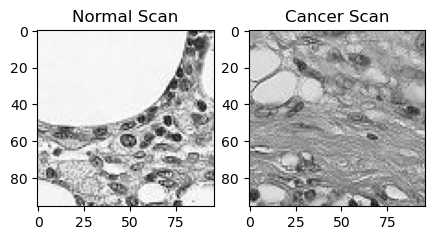

In [190]:
show_random_images()

In [225]:
class BreastScanDataset(Dataset):
    def __init__(self, paths, labels, transform = None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[index]
        label = torch.tensor([label])
        
        return image, label

In [226]:
train_dataset = BreastScanDataset(train_paths, train_labels)

In [229]:
resnet = resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [249]:
class BreastCancerNet(nn.Module):
    def __init__(self, pretrained = True):
        super(BreastCancerNet, self).__init__()
        self.lymphnode = resnet18(pretrained = pretrained)
        self.fc = nn.Linear(in_features = 512, out_features = 1)
        
    def forward(self, x):
        x = self.lymphnode.conv1(x)
        x = self.lymphnode.bn1(x)
        x = self.lymphnode.relu(x)
        x = self.lymphnode.maxpool(x)
        
        x = self.lymphnode.layer1(x)
        x = self.lymphnode.layer2(x)
        x = self.lymphnode.layer3(x)
        x = self.lymphnode.layer4(x)
        
        x = self.lymphnode.avgpool(x)
        
        x = x.view(x.size(0), 512)
        x = self.fc(x)
        
        return x

In [315]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize(size = (224, 224)),
    #transforms.CenterCrop((200,200)),
    #transforms.RandomRotation(degrees = 90),
    #transforms.RandomAdjustSharpness(10, p = 1),
    #transforms.ColorJitter(brightness=5, contrast=5, saturation=5, hue=0.5),
    #transforms.RandomInvert(p=1),
    #transforms.RandomGrayscale(p=1),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = BreastScanDataset(train_paths, train_labels, train_transform)
valid_dataset = BreastScanDataset(valid_paths, valid_labels, test_transform)

In [317]:
pretrained = True

model = BreastCancerNet(pretrained = pretrained)

lr = 5e-2

num_epochs = 10
train_batch_size = 32
valid_batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch_size, shuffle = True)

dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 5,
    "val": len(dataloaders["val"]) // 5
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr = lr)

In [319]:
model

BreastCancerNet(
  (lymphnode): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [320]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [321]:
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in tqdm(range(num_epochs), leave = False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                            leave = False,
                                            total = len(dataloaders[phase])):
                
                inputs = inputs.to(device)
                #labels = torch.nn.functional.one_hot(labels)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss / ((i+1) * batch_sizes[phase])
                    avg_acc = running_corrects / ((i+1) * batch_sizes[phase])
                    
                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss: {avg_loss} | acc: {avg_acc}")
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc> best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    
    print(f"training took {time_elapsed} seconds")
    
    print(classification_report(y_true=labels.tolist(), y_pred=preds.tolist()))
    
    model.load_state_dict(best_model_wts)
    return model

In [265]:
model = train_model(model, criterion, optimizer, num_epochs)
# with multiple augmentation criterion such as resize, center-cropping, color jitter, grayscale, randomInvert and RandomRotate
# lr = 0.001

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 1 / 10 | loss: 5.193713963031769 | acc: 0.53125
[train]: 1 / 10 | loss: 3.52815443277359 | acc: 0.5401785969734192
[train]: 1 / 10 | loss: 2.92713902592659 | acc: 0.512499988079071
[train]: 1 / 10 | loss: 2.481936665681692 | acc: 0.567307710647583
train Loss: 2.4165 Acc: 0.5758


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 1 / 10 | loss: 908.2433471679688 | acc: 0.6875
[val]: 1 / 10 | loss: 1239.8340250651042 | acc: 0.6458333134651184
[val]: 1 / 10 | loss: 1432.9754638671875 | acc: 0.6328125
[val]: 1 / 10 | loss: 1503.8317993164062 | acc: 0.5874999761581421
val Loss: 1582.9808 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 2 / 10 | loss: 2.7128745913505554 | acc: 0.6328125
[train]: 2 / 10 | loss: 2.578030858721052 | acc: 0.6428571343421936
[train]: 2 / 10 | loss: 2.2857661485671996 | acc: 0.625
[train]: 2 / 10 | loss: 2.1862929050738993 | acc: 0.598557710647583
train Loss: 2.0564 Acc: 0.5934


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 2 / 10 | loss: 0.7622803449630737 | acc: 0.359375
[val]: 2 / 10 | loss: 0.7603981296221415 | acc: 0.3645833432674408
[val]: 2 / 10 | loss: 0.7652599066495895 | acc: 0.3515625
[val]: 2 / 10 | loss: 0.7164119869470597 | acc: 0.36250001192092896
val Loss: 0.7541 Acc: 0.3816



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 3 / 10 | loss: 0.6813602447509766 | acc: 0.3984375
[train]: 3 / 10 | loss: 0.6975895166397095 | acc: 0.4375
[train]: 3 / 10 | loss: 0.6820513367652893 | acc: 0.47187501192092896
[train]: 3 / 10 | loss: 0.7095271853300241 | acc: 0.4975961446762085
train Loss: 0.7297 Acc: 0.5011


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 3 / 10 | loss: 0.5781023502349854 | acc: 0.71875
[val]: 3 / 10 | loss: 0.5979368289311727 | acc: 0.65625
[val]: 3 / 10 | loss: 0.6103654503822327 | acc: 0.6015625
[val]: 3 / 10 | loss: 0.5783219754695892 | acc: 0.5874999761581421
val Loss: 0.6088 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 4 / 10 | loss: 0.6989515423774719 | acc: 0.59375
[train]: 4 / 10 | loss: 0.6804910983358111 | acc: 0.59375
[train]: 4 / 10 | loss: 0.6719550013542175 | acc: 0.606249988079071
[train]: 4 / 10 | loss: 0.6663454083295969 | acc: 0.6129807829856873
train Loss: 0.6672 Acc: 0.6088


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 4 / 10 | loss: 0.6252223253250122 | acc: 0.5625
[val]: 4 / 10 | loss: 0.6777279575665792 | acc: 0.5833333134651184
[val]: 4 / 10 | loss: 0.6316943541169167 | acc: 0.6015625
[val]: 4 / 10 | loss: 0.5866313248872757 | acc: 0.5874999761581421
val Loss: 0.6175 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 5 / 10 | loss: 0.6475520730018616 | acc: 0.6015625
[train]: 5 / 10 | loss: 0.6341520377567836 | acc: 0.6116071343421936
[train]: 5 / 10 | loss: 0.6320091187953949 | acc: 0.606249988079071
[train]: 5 / 10 | loss: 0.6420871019363403 | acc: 0.6105769276618958
train Loss: 0.6438 Acc: 0.6132


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 5 / 10 | loss: 0.6081078350543976 | acc: 0.609375
[val]: 5 / 10 | loss: 0.6032577355702718 | acc: 0.625
[val]: 5 / 10 | loss: 0.6030292063951492 | acc: 0.6328125
[val]: 5 / 10 | loss: 0.5775313407182694 | acc: 0.5874999761581421
val Loss: 0.6079 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 6 / 10 | loss: 0.6538790911436081 | acc: 0.640625
[train]: 6 / 10 | loss: 0.7128044962882996 | acc: 0.6071428656578064
[train]: 6 / 10 | loss: 0.7050999343395233 | acc: 0.606249988079071
[train]: 6 / 10 | loss: 0.7037343795482929 | acc: 0.6177884340286255
train Loss: 0.7052 Acc: 0.6088


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 6 / 10 | loss: 0.674270749092102 | acc: 0.5625
[val]: 6 / 10 | loss: 0.6552687883377075 | acc: 0.6354166865348816
[val]: 6 / 10 | loss: 0.6556705832481384 | acc: 0.6328125
[val]: 6 / 10 | loss: 0.6264693140983582 | acc: 0.5874999761581421
val Loss: 0.6594 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 7 / 10 | loss: 0.6571223139762878 | acc: 0.6015625
[train]: 7 / 10 | loss: 0.8080266118049622 | acc: 0.59375
[train]: 7 / 10 | loss: 0.8393508136272431 | acc: 0.606249988079071
[train]: 7 / 10 | loss: 0.7964175389363215 | acc: 0.6033653616905212
train Loss: 0.7815 Acc: 0.6088


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 7 / 10 | loss: 0.6388251185417175 | acc: 0.609375
[val]: 7 / 10 | loss: 0.6330883900324503 | acc: 0.6145833134651184
[val]: 7 / 10 | loss: 0.6405905783176422 | acc: 0.59375
[val]: 7 / 10 | loss: 0.5985991328954696 | acc: 0.5874999761581421
val Loss: 0.6301 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 8 / 10 | loss: 0.579522043466568 | acc: 0.640625
[train]: 8 / 10 | loss: 0.6260681918689183 | acc: 0.6026785969734192
[train]: 8 / 10 | loss: 0.6249211072921753 | acc: 0.612500011920929
[train]: 8 / 10 | loss: 0.657607362820552 | acc: 0.620192289352417
train Loss: 0.7714 Acc: 0.6154


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 8 / 10 | loss: 0.6890552937984467 | acc: 0.515625
[val]: 8 / 10 | loss: 0.6763708790143331 | acc: 0.59375
[val]: 8 / 10 | loss: 0.6758573800325394 | acc: 0.59375
[val]: 8 / 10 | loss: 0.6368157744407654 | acc: 0.5874999761581421
val Loss: 0.6703 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 9 / 10 | loss: 0.8143901377916336 | acc: 0.625
[train]: 9 / 10 | loss: 0.9248585956437247 | acc: 0.6116071343421936
[train]: 9 / 10 | loss: 0.8627664506435394 | acc: 0.609375
[train]: 9 / 10 | loss: 0.8225482381307162 | acc: 0.6009615659713745
train Loss: 0.8204 Acc: 0.6000


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 9 / 10 | loss: 0.635267972946167 | acc: 0.65625
[val]: 9 / 10 | loss: 0.6651597420374552 | acc: 0.5833333134651184
[val]: 9 / 10 | loss: 0.658583015203476 | acc: 0.609375
[val]: 9 / 10 | loss: 0.6229474037885666 | acc: 0.5874999761581421
val Loss: 0.6557 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 10 / 10 | loss: 0.6472849696874619 | acc: 0.6015625
[train]: 10 / 10 | loss: 0.6504109501838684 | acc: 0.6428571343421936
[train]: 10 / 10 | loss: 0.6692101776599884 | acc: 0.6000000238418579
[train]: 10 / 10 | loss: 0.6625400598232563 | acc: 0.6033653616905212
train Loss: 0.6553 Acc: 0.6154


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 10 / 10 | loss: 0.636796623468399 | acc: 0.609375
[val]: 10 / 10 | loss: 0.6440232992172241 | acc: 0.6041666865348816
[val]: 10 / 10 | loss: 0.6443338394165039 | acc: 0.6015625
[val]: 10 / 10 | loss: 0.6037232726812363 | acc: 0.5874999761581421
val Loss: 0.6355 Acc: 0.6184

training took 164.6695945262909 seconds
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        17
           1       0.00      0.00      0.00         7

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24



C:\Users\vgare\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vgare\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vgare\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In the code above we used multiple augmentation criterion with a low learning rate of 0.001 however the model performed poorly. We can maximum validation accuracy of 61.84% with validation loss lingering around 0.65. To tackle this we raise the learning rate from 0.001 to 0.05 to move from local minima to global minima

In [290]:
model = train_model(model, criterion, optimizer, num_epochs)
# with Grayscale, Rotation and Resizing and normalization
# lr = 0.05

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 1 / 10 | loss: 2.073543071746826 | acc: 0.4921875
[train]: 1 / 10 | loss: 3.2309333767209734 | acc: 0.4866071343421936
[train]: 1 / 10 | loss: 3.3080121994018556 | acc: 0.4625000059604645
[train]: 1 / 10 | loss: 3.2131728575779843 | acc: 0.45673078298568726
train Loss: 2.9981 Acc: 0.4901


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 1 / 10 | loss: 65858.283203125 | acc: 0.65625
[val]: 1 / 10 | loss: 75336.48567708333 | acc: 0.6145833134651184
[val]: 1 / 10 | loss: 69543.1845703125 | acc: 0.640625
[val]: 1 / 10 | loss: 69740.78671875 | acc: 0.5874999761581421
val Loss: 73411.3544 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 2 / 10 | loss: 3.538854569196701 | acc: 0.5703125
[train]: 2 / 10 | loss: 2.4222284640584673 | acc: 0.53125
[train]: 2 / 10 | loss: 1.9158805847167968 | acc: 0.559374988079071
[train]: 2 / 10 | loss: 1.7265350772784307 | acc: 0.5480769276618958
train Loss: 1.6569 Acc: 0.5341


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 2 / 10 | loss: 16.78929328918457 | acc: 0.609375
[val]: 2 / 10 | loss: 16.89390754699707 | acc: 0.625
[val]: 2 / 10 | loss: 18.439098834991455 | acc: 0.625
[val]: 2 / 10 | loss: 17.782709980010985 | acc: 0.5874999761581421
val Loss: 18.7186 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 3 / 10 | loss: 0.7915347367525101 | acc: 0.4921875
[train]: 3 / 10 | loss: 0.8031737293515887 | acc: 0.53125
[train]: 3 / 10 | loss: 0.8084744453430176 | acc: 0.5218750238418579
[train]: 3 / 10 | loss: 0.7899971420948322 | acc: 0.5072115659713745
train Loss: 0.7922 Acc: 0.5121


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 3 / 10 | loss: 0.5895377397537231 | acc: 0.765625
[val]: 3 / 10 | loss: 0.5966829856236776 | acc: 0.7916666865348816
[val]: 3 / 10 | loss: 0.5949172526597977 | acc: 0.78125
[val]: 3 / 10 | loss: 0.5748594552278519 | acc: 0.7250000238418579
val Loss: 0.6051 Acc: 0.7632



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 4 / 10 | loss: 0.6475474536418915 | acc: 0.703125
[train]: 4 / 10 | loss: 0.6694573760032654 | acc: 0.65625
[train]: 4 / 10 | loss: 0.6879659116268158 | acc: 0.643750011920929
[train]: 4 / 10 | loss: 0.6790008361522968 | acc: 0.651442289352417
train Loss: 0.6827 Acc: 0.6462


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 4 / 10 | loss: 0.636929452419281 | acc: 0.625
[val]: 4 / 10 | loss: 0.6331992745399475 | acc: 0.625
[val]: 4 / 10 | loss: 0.6639257669448853 | acc: 0.578125
[val]: 4 / 10 | loss: 0.6227245956659317 | acc: 0.5687500238418579
val Loss: 0.6555 Acc: 0.5987



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 5 / 10 | loss: 0.7264256328344345 | acc: 0.671875
[train]: 5 / 10 | loss: 0.7466220089367458 | acc: 0.6651785969734192
[train]: 5 / 10 | loss: 0.7066651284694672 | acc: 0.668749988079071
[train]: 5 / 10 | loss: 0.7039441603880662 | acc: 0.6490384340286255
train Loss: 0.6970 Acc: 0.6527


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 5 / 10 | loss: 0.6439721286296844 | acc: 0.546875
[val]: 5 / 10 | loss: 0.6405536731084188 | acc: 0.5416666865348816
[val]: 5 / 10 | loss: 0.6317867785692215 | acc: 0.5390625
[val]: 5 / 10 | loss: 0.5947122752666474 | acc: 0.53125
val Loss: 0.6260 Acc: 0.5592



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 6 / 10 | loss: 0.7483410239219666 | acc: 0.578125
[train]: 6 / 10 | loss: 0.7327736020088196 | acc: 0.5401785969734192
[train]: 6 / 10 | loss: 0.6859408259391785 | acc: 0.543749988079071
[train]: 6 / 10 | loss: 0.6799705441181476 | acc: 0.567307710647583
train Loss: 0.6923 Acc: 0.5692


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 6 / 10 | loss: 0.6355946958065033 | acc: 0.625
[val]: 6 / 10 | loss: 0.6204368273417155 | acc: 0.625
[val]: 6 / 10 | loss: 0.62016561627388 | acc: 0.625
[val]: 6 / 10 | loss: 0.6024051994085312 | acc: 0.5874999761581421
val Loss: 0.6341 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 7 / 10 | loss: 0.6174524426460266 | acc: 0.6953125
[train]: 7 / 10 | loss: 0.6193270768438067 | acc: 0.6785714030265808
[train]: 7 / 10 | loss: 0.6264169931411743 | acc: 0.706250011920929
[train]: 7 / 10 | loss: 0.6077889593747946 | acc: 0.7211538553237915
train Loss: 0.6001 Acc: 0.7297


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 7 / 10 | loss: 0.5322884321212769 | acc: 0.71875
[val]: 7 / 10 | loss: 0.4671262204647064 | acc: 0.7916666865348816
[val]: 7 / 10 | loss: 0.4613325893878937 | acc: 0.7890625
[val]: 7 / 10 | loss: 0.4611461728811264 | acc: 0.731249988079071
val Loss: 0.4854 Acc: 0.7697



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 8 / 10 | loss: 0.5154446363449097 | acc: 0.7578125
[train]: 8 / 10 | loss: 0.5217081606388092 | acc: 0.7633928656578064
[train]: 8 / 10 | loss: 0.5250707864761353 | acc: 0.7562500238418579
[train]: 8 / 10 | loss: 0.5379144228421725 | acc: 0.7524038553237915
train Loss: 0.5536 Acc: 0.7495


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 8 / 10 | loss: 0.6906060874462128 | acc: 0.671875
[val]: 8 / 10 | loss: 0.6629602313041687 | acc: 0.6875
[val]: 8 / 10 | loss: 0.6500166952610016 | acc: 0.7109375
[val]: 8 / 10 | loss: 0.5840995237231255 | acc: 0.699999988079071
val Loss: 0.6148 Acc: 0.7368



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 9 / 10 | loss: 0.6046320647001266 | acc: 0.6484375
[train]: 9 / 10 | loss: 0.6038409726960319 | acc: 0.6473214030265808
[train]: 9 / 10 | loss: 0.5805803596973419 | acc: 0.6781250238418579
[train]: 9 / 10 | loss: 0.5610045080001538 | acc: 0.7043269276618958
train Loss: 0.5550 Acc: 0.7077


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 9 / 10 | loss: 0.5186817348003387 | acc: 0.765625
[val]: 9 / 10 | loss: 0.50473020474116 | acc: 0.7604166865348816
[val]: 9 / 10 | loss: 0.5248105674982071 | acc: 0.7265625
[val]: 9 / 10 | loss: 0.4943931892514229 | acc: 0.706250011920929
val Loss: 0.5204 Acc: 0.7434



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 10 / 10 | loss: 0.6232877597212791 | acc: 0.765625
[train]: 10 / 10 | loss: 0.5345949700900486 | acc: 0.78125
[train]: 10 / 10 | loss: 0.5243730932474137 | acc: 0.7749999761581421
[train]: 10 / 10 | loss: 0.520140141248703 | acc: 0.776442289352417
train Loss: 0.5252 Acc: 0.7714


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 10 / 10 | loss: 0.606790155172348 | acc: 0.734375
[val]: 10 / 10 | loss: 0.61034627755483 | acc: 0.75
[val]: 10 / 10 | loss: 0.6351715326309204 | acc: 0.7421875
[val]: 10 / 10 | loss: 0.627553042769432 | acc: 0.699999988079071
val Loss: 0.6606 Acc: 0.7368

training took 350.2024552822113 seconds
              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.54      0.88      0.67         8

    accuracy                           0.71        24
   macro avg       0.72      0.75      0.70        24
weighted avg       0.79      0.71      0.72        24



We removed a few augmentation parameters and changed the learning rate to 0.05 in the model above. We saw that we got a much better validation accuracy of 76.97% with a reduced validation loss of 0.48%. The precision also improved drastically.

In [298]:
model = train_model(model, criterion, optimizer, num_epochs)
# with Grayscale and Rotation
# lr = 0.05

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 1 / 10 | loss: 1.797640547156334 | acc: 0.5234375
[train]: 1 / 10 | loss: 2.231843888759613 | acc: 0.5535714030265808
[train]: 1 / 10 | loss: 1.914985328912735 | acc: 0.550000011920929
[train]: 1 / 10 | loss: 2.0242470502853394 | acc: 0.5625
train Loss: 1.9144 Acc: 0.5714


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 1 / 10 | loss: 1497.6347961425781 | acc: 0.65625
[val]: 1 / 10 | loss: 1341.6764119466145 | acc: 0.6354166865348816
[val]: 1 / 10 | loss: 1425.5840911865234 | acc: 0.6171875
[val]: 1 / 10 | loss: 1253.599691772461 | acc: 0.5874999761581421
val Loss: 1319.5786 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 2 / 10 | loss: 0.7778684943914413 | acc: 0.4453125
[train]: 2 / 10 | loss: 0.7354092257363456 | acc: 0.5357142686843872
[train]: 2 / 10 | loss: 0.7611473798751831 | acc: 0.5406249761581421
[train]: 2 / 10 | loss: 0.7507040408941416 | acc: 0.5721153616905212
train Loss: 0.7475 Acc: 0.5824


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 2 / 10 | loss: 281.2483596801758 | acc: 0.5625
[val]: 2 / 10 | loss: 260.0872548421224 | acc: 0.59375
[val]: 2 / 10 | loss: 259.14757919311523 | acc: 0.609375
[val]: 2 / 10 | loss: 245.2643829345703 | acc: 0.5874999761581421
val Loss: 258.1730 Acc: 0.6184



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 3 / 10 | loss: 1.2045308649539948 | acc: 0.6875
[train]: 3 / 10 | loss: 1.1627247333526611 | acc: 0.6607142686843872
[train]: 3 / 10 | loss: 0.9978379487991333 | acc: 0.659375011920929
[train]: 3 / 10 | loss: 1.0040538952900813 | acc: 0.6658653616905212
train Loss: 0.9654 Acc: 0.6725


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 3 / 10 | loss: 49.756551176309586 | acc: 0.609375
[val]: 3 / 10 | loss: 33.3981286684672 | acc: 0.6458333134651184
[val]: 3 / 10 | loss: 26.36971950531006 | acc: 0.6796875
[val]: 3 / 10 | loss: 21.197475600242615 | acc: 0.643750011920929
val Loss: 22.3131 Acc: 0.6776



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 4 / 10 | loss: 0.9302631765604019 | acc: 0.515625
[train]: 4 / 10 | loss: 1.288168225969587 | acc: 0.5625
[train]: 4 / 10 | loss: 1.091775542497635 | acc: 0.628125011920929
[train]: 4 / 10 | loss: 0.9710267461263217 | acc: 0.6394230723381042
train Loss: 0.9393 Acc: 0.6462


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 4 / 10 | loss: 0.6046785414218903 | acc: 0.65625
[val]: 4 / 10 | loss: 0.6084988315900167 | acc: 0.6770833134651184
[val]: 4 / 10 | loss: 0.6000576764345169 | acc: 0.6953125
[val]: 4 / 10 | loss: 0.5625038266181945 | acc: 0.6812499761581421
val Loss: 0.5921 Acc: 0.7171



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 5 / 10 | loss: 0.7585887610912323 | acc: 0.6171875
[train]: 5 / 10 | loss: 0.7043612854821342 | acc: 0.6071428656578064
[train]: 5 / 10 | loss: 0.7196903228759766 | acc: 0.6000000238418579
[train]: 5 / 10 | loss: 0.9211681989523081 | acc: 0.6394230723381042
train Loss: 0.8936 Acc: 0.6462


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 5 / 10 | loss: 0.5303521752357483 | acc: 0.859375
[val]: 5 / 10 | loss: 0.5586856404940287 | acc: 0.8020833134651184
[val]: 5 / 10 | loss: 0.5476794689893723 | acc: 0.8046875
[val]: 5 / 10 | loss: 0.5153415471315383 | acc: 0.7562500238418579
val Loss: 0.5425 Acc: 0.7961



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 6 / 10 | loss: 0.5949958115816116 | acc: 0.7421875
[train]: 6 / 10 | loss: 0.5727156230381557 | acc: 0.7455357313156128
[train]: 6 / 10 | loss: 0.5577410519123077 | acc: 0.75
[train]: 6 / 10 | loss: 0.5416484062488263 | acc: 0.7572115659713745
train Loss: 0.5328 Acc: 0.7626


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 6 / 10 | loss: 0.4368150383234024 | acc: 0.8125
[val]: 6 / 10 | loss: 0.4470260540644328 | acc: 0.8229166865348816
[val]: 6 / 10 | loss: 0.41962631791830063 | acc: 0.8359375
[val]: 6 / 10 | loss: 0.43059428334236144 | acc: 0.768750011920929
val Loss: 0.4533 Acc: 0.8092



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 7 / 10 | loss: 0.7074328809976578 | acc: 0.75
[train]: 7 / 10 | loss: 0.5788682103157043 | acc: 0.7901785969734192
[train]: 7 / 10 | loss: 0.5766310632228852 | acc: 0.7718750238418579
[train]: 7 / 10 | loss: 0.6774322115457975 | acc: 0.7572115659713745
train Loss: 0.6805 Acc: 0.7516


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 7 / 10 | loss: 0.6147299706935883 | acc: 0.75
[val]: 7 / 10 | loss: 0.607623298962911 | acc: 0.75
[val]: 7 / 10 | loss: 0.6277998089790344 | acc: 0.7265625
[val]: 7 / 10 | loss: 0.624057126045227 | acc: 0.668749988079071
val Loss: 0.6569 Acc: 0.7039



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 8 / 10 | loss: 0.641776978969574 | acc: 0.6484375
[train]: 8 / 10 | loss: 0.9010397366115025 | acc: 0.6339285969734192
[train]: 8 / 10 | loss: 0.8196878731250763 | acc: 0.625
[train]: 8 / 10 | loss: 0.7668965000372666 | acc: 0.6466346383094788
train Loss: 0.7948 Acc: 0.6527


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 8 / 10 | loss: 9.431941509246826 | acc: 0.640625
[val]: 8 / 10 | loss: 11.047828674316406 | acc: 0.6666666865348816
[val]: 8 / 10 | loss: 13.991405487060547 | acc: 0.6640625
[val]: 8 / 10 | loss: 15.205370044708252 | acc: 0.643750011920929
val Loss: 16.0057 Acc: 0.6776



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 9 / 10 | loss: 0.6497289091348648 | acc: 0.671875
[train]: 9 / 10 | loss: 0.6435165745871407 | acc: 0.65625
[train]: 9 / 10 | loss: 0.6864669620990753 | acc: 0.6187499761581421
[train]: 9 / 10 | loss: 0.6824638889386103 | acc: 0.6153846383094788
train Loss: 0.6719 Acc: 0.6198


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 9 / 10 | loss: 30.003320693969727 | acc: 0.5625
[val]: 9 / 10 | loss: 25.369866689046223 | acc: 0.5625
[val]: 9 / 10 | loss: 19.670658588409424 | acc: 0.609375
[val]: 9 / 10 | loss: 18.79532175064087 | acc: 0.5687500238418579
val Loss: 19.7845 Acc: 0.5987



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 10 / 10 | loss: 0.7909172177314758 | acc: 0.71875
[train]: 10 / 10 | loss: 0.687011854989188 | acc: 0.7232142686843872
[train]: 10 / 10 | loss: 0.7184037864208221 | acc: 0.703125
[train]: 10 / 10 | loss: 0.6921314276181735 | acc: 0.7043269276618958
train Loss: 0.6969 Acc: 0.6989


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 10 / 10 | loss: 0.6529963910579681 | acc: 0.625
[val]: 10 / 10 | loss: 0.6158721645673116 | acc: 0.6666666865348816
[val]: 10 / 10 | loss: 0.6433888375759125 | acc: 0.65625
[val]: 10 / 10 | loss: 0.6475693136453629 | acc: 0.59375
val Loss: 0.6817 Acc: 0.6250

training took 96.72470450401306 seconds
              precision    recall  f1-score   support

           0       0.75      0.35      0.48        17
           1       0.31      0.71      0.43         7

    accuracy                           0.46        24
   macro avg       0.53      0.53      0.46        24
weighted avg       0.62      0.46      0.47        24



In the above model we further removed resizing augmentation as it was taking too long to train the model when resizing to (224,224) pixels from (96,96) pixels. This led to quicker training and improved model accuracy to 80.92%. However, the precision scores slightly dropped here.

In [323]:
model = train_model(model, criterion, optimizer, num_epochs)
# Only Normalize without any other augmentation
# Lr = 0.05
# model accuracy improved to 82.89%
# The precision for both positive and negative classes also improved

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 1 / 10 | loss: 0.6303335875272751 | acc: 0.7109375
[train]: 1 / 10 | loss: 0.6020825547831399 | acc: 0.7232142686843872
[train]: 1 / 10 | loss: 0.6013462990522385 | acc: 0.706250011920929
[train]: 1 / 10 | loss: 0.5700593453187209 | acc: 0.7379807829856873
train Loss: 0.5959 Acc: 0.7209


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 1 / 10 | loss: 1.0560608208179474 | acc: 0.625
[val]: 1 / 10 | loss: 1.6761408050855 | acc: 0.625
[val]: 1 / 10 | loss: 1.4080122262239456 | acc: 0.625
[val]: 1 / 10 | loss: 1.2083460539579391 | acc: 0.6000000238418579
val Loss: 1.2719 Acc: 0.6316



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 2 / 10 | loss: 1.80233833193779 | acc: 0.5625
[train]: 2 / 10 | loss: 1.530091907296862 | acc: 0.5758928656578064
[train]: 2 / 10 | loss: 1.2890966653823852 | acc: 0.5874999761581421
[train]: 2 / 10 | loss: 1.1418133836526136 | acc: 0.598557710647583
train Loss: 1.0898 Acc: 0.6132


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 2 / 10 | loss: 14.790156364440918 | acc: 0.765625
[val]: 2 / 10 | loss: 14.817012468973795 | acc: 0.75
[val]: 2 / 10 | loss: 13.556708335876465 | acc: 0.75
[val]: 2 / 10 | loss: 11.839256501197815 | acc: 0.7124999761581421
val Loss: 12.4624 Acc: 0.7500



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 3 / 10 | loss: 0.7374498099088669 | acc: 0.6015625
[train]: 3 / 10 | loss: 0.6745943597384861 | acc: 0.5982142686843872
[train]: 3 / 10 | loss: 0.7854062497615815 | acc: 0.637499988079071
[train]: 3 / 10 | loss: 0.7368424030450674 | acc: 0.6346153616905212
train Loss: 0.7192 Acc: 0.6396


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 3 / 10 | loss: 0.862510621547699 | acc: 0.8125
[val]: 3 / 10 | loss: 0.6964584589004517 | acc: 0.8020833134651184
[val]: 3 / 10 | loss: 3.227171391248703 | acc: 0.8046875
[val]: 3 / 10 | loss: 2.6438832387328146 | acc: 0.75
val Loss: 2.7830 Acc: 0.7895



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 4 / 10 | loss: 0.6216750741004944 | acc: 0.734375
[train]: 4 / 10 | loss: 0.6484321270670209 | acc: 0.7053571343421936
[train]: 4 / 10 | loss: 0.5989963382482528 | acc: 0.731249988079071
[train]: 4 / 10 | loss: 0.606249233851066 | acc: 0.7259615659713745
train Loss: 0.6047 Acc: 0.7209


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 4 / 10 | loss: 0.7490854561328888 | acc: 0.6875
[val]: 4 / 10 | loss: 0.6922968228658041 | acc: 0.6979166865348816
[val]: 4 / 10 | loss: 0.6577835530042648 | acc: 0.6875
[val]: 4 / 10 | loss: 0.5889578953385353 | acc: 0.668749988079071
val Loss: 0.6200 Acc: 0.7039



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 5 / 10 | loss: 0.6060367524623871 | acc: 0.671875
[train]: 5 / 10 | loss: 0.5798781854765755 | acc: 0.6741071343421936
[train]: 5 / 10 | loss: 0.6916528642177582 | acc: 0.640625
[train]: 5 / 10 | loss: 0.6803017121094924 | acc: 0.661057710647583
train Loss: 0.6725 Acc: 0.6593


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 5 / 10 | loss: 0.5612123608589172 | acc: 0.71875
[val]: 5 / 10 | loss: 0.5331443548202515 | acc: 0.7395833134651184
[val]: 5 / 10 | loss: 0.5308849364519119 | acc: 0.7421875
[val]: 5 / 10 | loss: 0.514234972000122 | acc: 0.6937500238418579
val Loss: 0.5413 Acc: 0.7303



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 6 / 10 | loss: 0.5633805245161057 | acc: 0.6875
[train]: 6 / 10 | loss: 0.609045684337616 | acc: 0.6785714030265808
[train]: 6 / 10 | loss: 0.5857888758182526 | acc: 0.6968749761581421
[train]: 6 / 10 | loss: 0.64057123202544 | acc: 0.7067307829856873
train Loss: 0.6278 Acc: 0.7143


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 6 / 10 | loss: 0.46392491459846497 | acc: 0.765625
[val]: 6 / 10 | loss: 0.4552494287490845 | acc: 0.7604166865348816
[val]: 6 / 10 | loss: 0.48312999308109283 | acc: 0.7734375
[val]: 6 / 10 | loss: 0.45556299537420275 | acc: 0.731249988079071
val Loss: 0.4795 Acc: 0.7697



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 7 / 10 | loss: 0.5913912281394005 | acc: 0.7109375
[train]: 7 / 10 | loss: 0.5513621951852526 | acc: 0.7366071343421936
[train]: 7 / 10 | loss: 0.5475167125463486 | acc: 0.721875011920929
[train]: 7 / 10 | loss: 0.5721489076430981 | acc: 0.7091346383094788
train Loss: 0.5663 Acc: 0.7099


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 7 / 10 | loss: 0.4822661578655243 | acc: 0.734375
[val]: 7 / 10 | loss: 0.4541634221871694 | acc: 0.75
[val]: 7 / 10 | loss: 0.45207469910383224 | acc: 0.765625
[val]: 7 / 10 | loss: 0.43482475727796555 | acc: 0.731249988079071
val Loss: 0.4577 Acc: 0.7697



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 8 / 10 | loss: 0.524489089846611 | acc: 0.75
[train]: 8 / 10 | loss: 0.48984407101358685 | acc: 0.7901785969734192
[train]: 8 / 10 | loss: 0.49236557483673093 | acc: 0.784375011920929
[train]: 8 / 10 | loss: 0.5076471979801471 | acc: 0.7692307829856873
train Loss: 0.5107 Acc: 0.7604


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 8 / 10 | loss: 0.44103318452835083 | acc: 0.75
[val]: 8 / 10 | loss: 0.463188111782074 | acc: 0.75
[val]: 8 / 10 | loss: 0.4671998769044876 | acc: 0.765625
[val]: 8 / 10 | loss: 0.4511182874441147 | acc: 0.7437499761581421
val Loss: 0.4749 Acc: 0.7829



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 9 / 10 | loss: 0.5101481229066849 | acc: 0.7421875
[train]: 9 / 10 | loss: 0.5017084862504687 | acc: 0.7455357313156128
[train]: 9 / 10 | loss: 0.5302071392536163 | acc: 0.75
[train]: 9 / 10 | loss: 0.5159732676469363 | acc: 0.7668269276618958
train Loss: 0.5305 Acc: 0.7648


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 9 / 10 | loss: 0.5143623948097229 | acc: 0.84375
[val]: 9 / 10 | loss: 0.5113275845845541 | acc: 0.84375
[val]: 9 / 10 | loss: 0.5047303438186646 | acc: 0.828125
[val]: 9 / 10 | loss: 0.47258559614419937 | acc: 0.7875000238418579
val Loss: 0.4975 Acc: 0.8289



  0%|          | 0/15 [00:00<?, ?it/s]

[train]: 10 / 10 | loss: 0.6017330437898636 | acc: 0.703125
[train]: 10 / 10 | loss: 0.6023830856595721 | acc: 0.7455357313156128
[train]: 10 / 10 | loss: 0.6124690741300582 | acc: 0.7406250238418579
[train]: 10 / 10 | loss: 0.6442943100745862 | acc: 0.7403846383094788
train Loss: 0.6544 Acc: 0.7407


  0%|          | 0/5 [00:00<?, ?it/s]

[val]: 10 / 10 | loss: 0.49664366245269775 | acc: 0.765625
[val]: 10 / 10 | loss: 0.4752075970172882 | acc: 0.7708333134651184
[val]: 10 / 10 | loss: 0.4758124426007271 | acc: 0.7734375
[val]: 10 / 10 | loss: 0.45581667125225067 | acc: 0.737500011920929
val Loss: 0.4798 Acc: 0.7763

training took 83.37504482269287 seconds
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        14
           1       0.86      0.60      0.71        10

    accuracy                           0.79        24
   macro avg       0.81      0.76      0.77        24
weighted avg       0.80      0.79      0.78        24



In the final model execution above we removed all augmentation criterion and included only normalization of our data. We saw a consistently good performance for both training and validation datasets. The val accuracy improved to 82.89%. The training and validation loss difference is also reducing gradually keeping under 10%. We can say that our model is not overfitting. Also, we saw that the precision scores greatly improved here. Hence, we save this as our final model.

In [324]:
torch.save(model, f = './resnet18model.pth')